In [1]:
using Compat, Random, Distributions, Plots, LinearAlgebra, Statistics, LaTeXStrings, SparseArrays, CPUTime, JLD2
using SpecialFunctions, GSL, SuiteSparse, Distributed, Roots, NBInclude
gr(fmt=:png)
e = 2.7182818284
Random.seed!(1);

In [2]:
addprocs(2)
@everywhere using Compat, Random, Distributions, Plots, LinearAlgebra, Statistics, LaTeXStrings, SparseArrays, CPUTime, JLD2, SpecialFunctions, GSL, SuiteSparse, Distributed
@everywhere using SharedArrays, ParallelDataTransfer, Roots, NBInclude
@everywhere @nbinclude("setup.ipynb")
@everywhere using .setup, .functions
procs()

3-element Vector{Int64}:
 1
 2
 3

In [3]:
# set the time grid
T = 600
dt = T/1200
T_bar = 24
time_grid = collect(0:dt:T)
L = length(time_grid)
t_grid = dt, L
ψ = 0.02/12*exp.(-time_grid/12*1.15)

# set up matrices that convert monthly responses to quarterly
Lq = Int64((L-1)/8)
A = Diagonal(ones(Lq))
b = ones(8)'/8
Q = hcat(kron(A,b),zeros(Lq));

In [4]:
# compute steady-state statistics
@load "steady_state_output.jld2"
@load "external_parameters.jld2"
par_grid_N, par_grid_T = deepcopy(par_grid), deepcopy(par_grid)
par_grid_N.labor = par_grid.labor * prod_N
par_grid_N.productivity = par_grid.productivity * prod_N
par_grid_T.labor = par_grid.labor * prod_T
par_grid_T.productivity = par_grid.productivity * prod_T
aN = distr_N'*par_grid.assets
aT = distr_T'*par_grid.assets
a = par.ζ_T*aT + par.ζ_N*aN

@time paral = pmap(q_response,[value_N,value_T],[distr_N,distr_T],(1-par.τ_w)*[ones(L),ones(L)],[par.r_d*ones(L),par.r_d*ones(L)],[zeros(L),zeros(L)],[true,true],[par,par],[par_grid_N,par_grid_T],[t_grid,t_grid])
 
Cq_N, Lq_N, v_N = paral[1]
Cq_T, Lq_T, v_T = paral[2]

ss_objects = Cq_T, Cq_N, distr_T, distr_N;

 41.474326 seconds (20.79 M allocations: 1.135 GiB, 0.86% gc time, 11.65% compilation time)


In [5]:
# compute the first-quarter responses for all combinations of elasticities and monetary policy rules

Δvars, biases_T, biases_N, P_arr, E_arr, r_arr, μ_arr, cN_arr, cT_arr, wN_arr, wT_arr = [], [], [], [], [], [], [], [], [], [], []

ress = ["peg_low_elast", "low_075", "low_050", "low_025", "float_low_elast", "low_025_neg", "low_050_neg", "low_075_neg", 
    "peg", "mix_075", "mix_050", "mix_025", "float", "mix_025_neg", "mix_050_neg", "mix_075_neg", 
    "peg_high_elast", "high_075", "high_050", "high_025", "float_high_elast", "high_025_neg", "high_050_neg", "high_075_neg"]

for i in 1:length(ress)
    @load "transition_results/"*ress[i]*".jld2" res_this
    
    print(ress[i]," ")

    @time paral = pmap(q_response,[value_N,value_T],[distr_N,distr_T],(1-par.τ_w)*[res_this.wN_sequence,res_this.wT_sequence],[res_this.rd_sequence,res_this.rd_sequence],[zeros(L),zeros(L)],[true,true],[par,par],[par_grid_N,par_grid_T],[t_grid,t_grid])
    Call_N, Lall_N, Wall_N = paral[1]
    Call_T, Lall_T, Wall_T = paral[2]
    
    var_Q_total, var_total, change_var, disp_T, disp_N, bias_T, bias_N, betw = print_decomposition(Call_T,Call_N,par,par_grid,ss_objects)
    append!(Δvars,change_var)
    append!(biases_T,bias_T)
    append!(biases_N,bias_N)
    
    P_seq = exp.(cumsum(vcat(0,res_this.π_sequence[1:end-1]) * dt))
    E_seq = P_seq.*res_this.pF_sequence
    
    append!(P_arr,100*(Q*P_seq)[1]-100)
    append!(E_arr,100*(Q*E_seq)[1]-100)
    append!(r_arr,100*12*((Q*res_this.rd_sequence)[1]-par.r_d))
    append!(μ_arr,100*12*(Q*res_this.μ_sequence)[1])
    append!(cN_arr,100*(Q*res_this.cN_sequence)[1]/res_this.cN_sequence[end]-100)
    append!(cT_arr,100*(Q*res_this.cT_sequence)[1]/res_this.cT_sequence[end]-100)
    append!(wN_arr,100*(Q*res_this.wN_sequence)[1]-100)
    append!(wT_arr,100*(Q*res_this.wT_sequence)[1]-100)
    
    print("\nP = ",round(P_arr[end],digits=2)," E = ",round(E_arr[end],digits=2)," r = ",round(r_arr[end],digits=2)," μ = ",round(μ_arr[end],digits=2))
    print(", cN = ",round(cN_arr[end],digits=2)," cT = ",round(cT_arr[end],digits=2)," wN = ",round(wN_arr[end],digits=2)," wT = ",round(wT_arr[end],digits=2),"\n")
end

peg_low_elast  23.189288 seconds (25.97 k allocations: 2.216 MiB, 0.14% compilation time)
change in variance = 1.59%: dispersion T = 0.05%, dispersion N = 0.36%, wealth bias T = 8.13%, wealth bias N = 36.33%, between = 55.12%
P = -0.78 E = 0.0 r = 4.08 μ = 2.38, cN = -0.48 cT = -0.1 wN = -1.06 wT = -0.06
low_075  23.204588 seconds (1.17 k allocations: 868.484 KiB)
change in variance = -0.26%: dispersion T = -0.86%, dispersion N = -0.22%, wealth bias T = 168.53%, wealth bias N = 94.24%, between = -161.69%
P = 1.38 E = 3.33 r = -0.72 μ = -2.42, cN = 0.7 cT = 0.88 wN = 0.88 wT = 1.39
low_050  23.501237 seconds (1.18 k allocations: 868.438 KiB)
change in variance = 0.18%: dispersion T = 0.63%, dispersion N = 0.02%, wealth bias T = -168.84%, wealth bias N = -30.36%, between = 298.56%
P = 0.56 E = 1.81 r = 0.08 μ = -1.62, cN = 0.02 cT = 0.26 wN = 0.07 wT = 0.66
low_025  21.532459 seconds (1.14 k allocations: 867.312 KiB)
change in variance = 0.32%: dispersion T = 0.26%, dispersion N = 0.0%, 

In [6]:
# compute the first-quarter aggregate responses

ϕϵ_arr = [-Inf, 0.75, 0.5, 0.25, 0, -0.25, -0.5, -0.75]
ϕϵ_arr = repeat(ϕϵ_arr,3)
ϕπ_arr = 1.5*(ones(length(ϕϵ_arr))-ϕϵ_arr)
price_level_arr, inf_arr, psi_arr, logE_arr, π_arr, initial_depr, eventual_depr = [], [], [], [], [], [], []

for i in 1:length(ress)
    @load "transition_results/"*ress[i]*".jld2" res_this
    
    P_seq = exp.(cumsum(vcat(0,res_this.π_sequence[1:end-1]) * dt))
    E_seq = P_seq.*res_this.pF_sequence
    append!(initial_depr,100*(Q*E_seq)[1]-100)
    append!(eventual_depr,100*(Q*E_seq)[end]-100)
    append!(logE_arr,(Q*log.(E_seq))[1])
    append!(π_arr,100*12*(Q*res_this.π_sequence)[1])
end

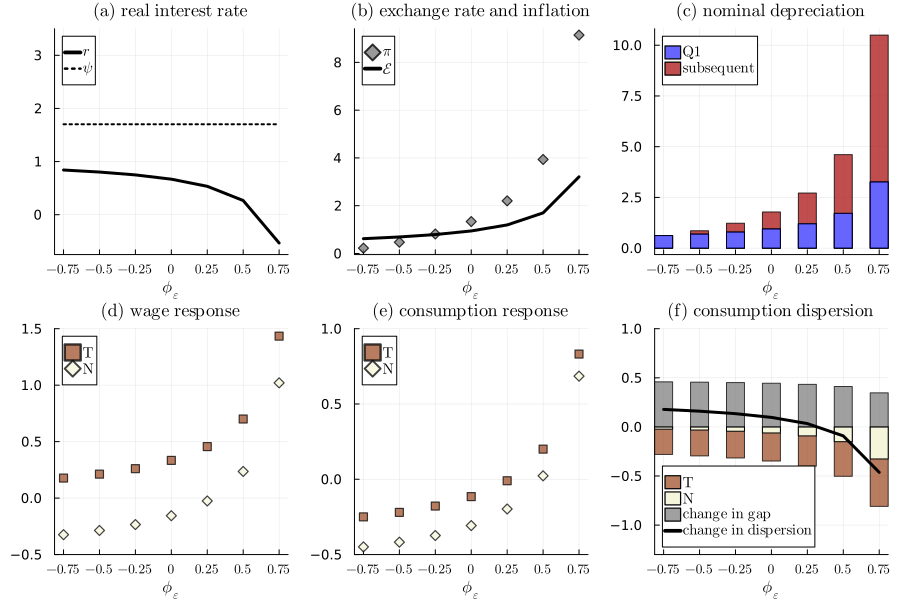

In [7]:
# plot

degrees_of_fear = reverse([L"0.75",L"0.5",L"0.25",L"0",L"-0.25",L"-0.5",L"-0.75"])
i_arr = π_arr + r_arr
Edot_arr = π_arr + μ_arr
mean_total = sum(par.ζ_T*distr_T.*log.(Cq_T) + par.ζ_N*distr_N.*log.(Cq_N))
var_total = sum(par.ζ_T*distr_T.* (log.(Cq_T)-mean_total*ones(par_grid.K*par_grid.N)).^2 + par.ζ_N*distr_N.* (log.(Cq_N)-mean_total*ones(par_grid.K*par_grid.N)).^2)
Δgap = Δvars - biases_T - biases_N

plot_rate = plot(1:7,reverse(r_arr[10:16]),xticks=(1:7,degrees_of_fear),lw=3,color=:black,label=L"r",title=L"\mathrm{(a)\ real\ interest\ rate}",ylim=[-0.75,3.5],legend=:topleft)
plot!(1:7,100*12*(Q*ψ)[1]*ones(7),ls=:dot,lw=2,color=:black,label=L"\psi")
plot_E = scatter(1:7,reverse(π_arr[10:16]),xticks=(1:7,degrees_of_fear),markershape=:diamond,ms=5,ma=0.8,color=:grey,label=L"\pi",legend=:topleft)
plot!(1:7,100*reverse(logE_arr[10:16]),xticks=(1:7,degrees_of_fear),color=:black,label=L"\mathcal{E}",lw=3,title=L"\mathrm{(b)\ exchange\ rate\ and\ inflation}")
plot_depr = bar(1:7,reverse(initial_depr[10:16]),xticks=(1:7,degrees_of_fear),color=:blue,alpha=0.6,label=L"\mathrm{Q1}",legend=:topleft,bar_width=0.5)
bar!(1:7,reverse(eventual_depr[10:16]),xticks=(1:7,degrees_of_fear),color=:firebrick,alpha=0.8,label=L"\mathrm{subsequent}",title=L"\mathrm{(c)\ nominal\ depreciation}",bar_width=0.5)
bar!(1:7,reverse(initial_depr[10:16]),xticks=(1:7,degrees_of_fear),color=:white,alpha=1.0,label="",bar_width=0.5)
bar!(1:7,reverse(initial_depr[10:16]),xticks=(1:7,degrees_of_fear),color=:blue,alpha=0.6,label="",bar_width=0.5)
plot_w = scatter(1:7,reverse(wT_arr[10:16]),xticks=(1:7,degrees_of_fear),color=:sienna,markershape=:rect,ms=4,ma=0.75,label=L"\mathrm{T}",title=L"\mathrm{(d)\ wage\ response}",ylim=[-0.5,1.5])
scatter!(1:7,reverse(wN_arr[10:16]),xticks=(1:7,degrees_of_fear),color=:beige,ms=5,ma=0.75,markershape=:diamond,label=L"\mathrm{N}",legend=:topleft)
plot_C = scatter(1:7,reverse(cT_arr[10:16]),xticks=(1:7,degrees_of_fear),color=:sienna,markershape=:rect,ms=4,ma=0.75,label=L"\mathrm{T}",title=L"\mathrm{(e)\ consumption\ response}",ylim=[-0.5,1.0])
scatter!(1:7,reverse(cN_arr[10:16]),xticks=(1:7,degrees_of_fear),color=:beige,ms=5,ma=0.75,markershape=:diamond,label=L"\mathrm{N}",legend=:topleft)
plot_var = bar(1:7,reverse(100*(biases_T[10:16]+min.(0,biases_N[10:16]))/var_total),xticks=(1:7,degrees_of_fear),color=:sienna,alpha=0.75,label=L"\mathrm{T}",title=L"\mathrm{(f)\ consumption\ dispersion}",bar_width=0.5)
bar!(1:7,100*reverse(biases_N[10:16]/var_total),xticks=(1:7,degrees_of_fear),color=:beige,alpha=1.0,label=L"\mathrm{N}",legend=:topleft,ylim=[-1.3,1.0],bar_width=0.5)
bar!(1:7,100*reverse(Δgap[10:16]/var_total),xticks=(1:7,degrees_of_fear),color=:grey,alpha=0.75,label=L"\mathrm{change\ in\ gap}",legend=:bottomleft,ylim=[-1.3,1.0],bar_width=0.5)
plot!(1:7,100*reverse(Δvars[10:16]/var_total),xticks=(1:7,degrees_of_fear),color=:black,lw=3,label=L"\mathrm{change\ in\ dispersion}")
l = @layout[a a a; a a a]
plot(plot_rate,plot_E,plot_depr,plot_w,plot_C,plot_var,layout=l,size=(900,600),titlefontsize=12,legendfontsize=10,tickfontsize=9,bottom_margin=0.05Plots.cm,xlabel=L"\phi_\epsilon",xlim=[0.75,7.25])

In [8]:
png("graphs/alternative_rules.png")

"graphs/alternative_rules.png"